In [294]:
%load_ext autoreload
%autoreload 2

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import auc, f1_score, roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from datetime import datetime
from src.model_functions import thresh_selection, odds_to_prob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
data = pd.read_csv('data/model/model_pat.csv')

In [188]:
new_patients = [8491,
 8494,
 8495,
 8496,
 8497,
 8498,
 8500,
 8501,
 8502,
 8503,
 8504,
 8505,
 8507,
 8510,
 8511,
 8512,
 8514,
 8515,
 8517,
 8519,
 8520,
 8521,
 8522,
 8523,
 8524,
 8526,
 8527,
 8528,
 8529,
 8530,
 8531,
 8532,
 8533,
 8534,
 8535,
 8537,
 8540,
 8542,
 8544,
 8546,
 8549,
 7948,
 8087,
 8314,
 8318,
 8319,
 8321,
 8322,
 8324,
 8327,
 8328,
 8330,
 8331,
 8333,
 8334,
 8335,
 8337,
 8340,
 8341,
 8342,
 8343,
 8344,
 8345,
 8346,
 8347,
 8348,
 8349,
 8350,
 8352,
 8353,
 8354,
 8355,
 8356,
 8358,
 8359,
 8360,
 8361,
 8362,
 8364,
 8365,
 8366,
 8368,
 8369,
 8370,
 8371,
 8372,
 8374,
 8375,
 8384,
 8385,
 8386,
 8387,
 8388,
 8393,
 8394,
 8395,
 8396,
 8397,
 8398,
 8399,
 8400,
 8401,
 8402,
 8403,
 8406,
 8407,
 8408,
 8409,
 8410,
 8411,
 8412,
 8413,
 8414,
 8415,
 8416,
 8417,
 8418,
 8419,
 8421,
 8422,
 8423,
 8425,
 8426,
 8427,
 8428,
 8429,
 8430,
 8431,
 8432,
 8433,
 8434,
 8435,
 8437,
 8438,
 8440,
 8441,
 8443,
 8444,
 8445,
 8446,
 8447,
 8448,
 8449,
 8451,
 8452,
 8453,
 8456,
 8457,
 8459,
 8460,
 8461,
 8462,
 8466,
 8468,
 8469,
 8472,
 8473,
 8476,
 8479,
 8482,
 8484,
 8485,
 8486,
 8487,
 8488,
 8489]

In [301]:
clean_set = data[~data['PatNum'].isin(new_patients)]
churn_rate_through_2016 = clean_set.churn.sum()/len(clean_set)
churn_rate_through_2016
holdout = data[data['PatNum'].isin(new_patients)]
relabels = np.where(holdout['LastVisit'] >= 210, 1, 0)
holdout.churn = relabels
holdoutX = holdout.drop(['PatNum', 'PatStatus', 'LastVisit', 'churn'], axis=1)
holdouty = holdout.churn

0.4606440071556351

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [321]:
1 - 2500/15000

0.8333333333333334

In [ ]:
#churn_under_30 = data[(data['tenure'] < 30)&(data['churn'] == 1)]['PatNum'].to_list()

In [56]:
appt = pd.read_csv('data/interm/appt_2016.csv')

In [59]:
pat = pd.read_csv('data/interm/patients_2016.csv')

In [62]:
merged_df = appt.merge(pat.loc[:,['PatNum','DateFirstVisit']])

In [74]:
merged_df = merged_df[merged_df['PatNum'].isin(churn_under_30)]
#merged_df.sort_values('AptDate')

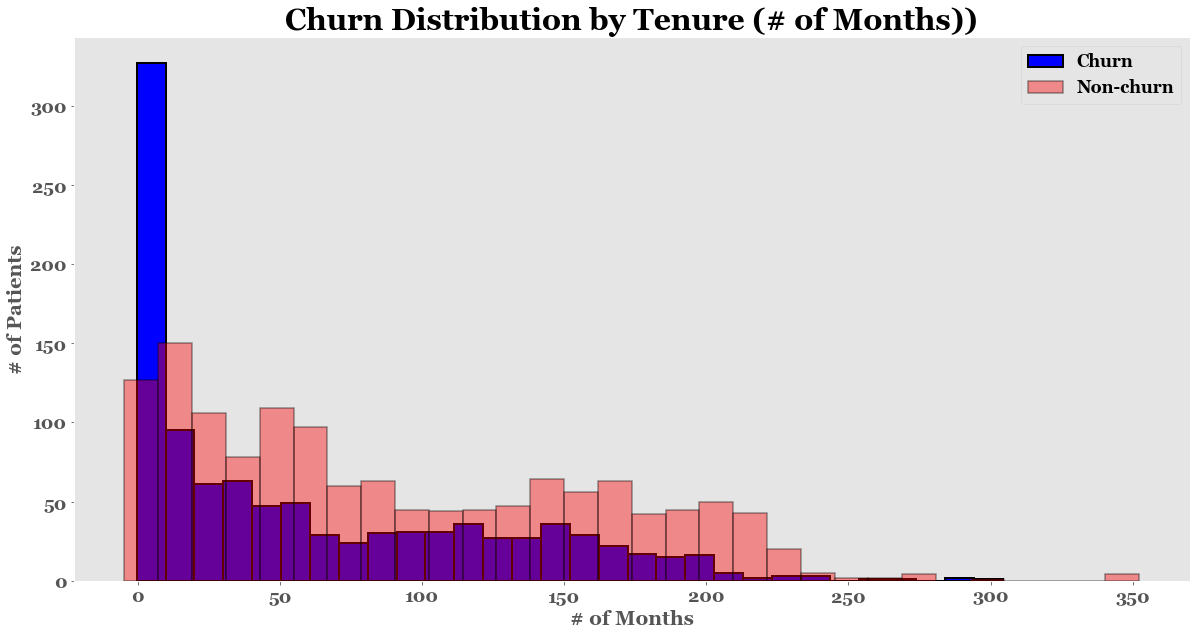

In [334]:
plt.style.use('ggplot')
tenure_non_churn = data[data['churn'] == 0]['tenure']/30
tenure_churn = data[data['churn'] == 1]['tenure']/30
hist_churn = plt.hist(tenure_churn, bins=30, edgecolor='black', lw=2, color='blue', label='Churn')
hist_non_churn = plt.hist(tenure_non_churn, bins=30, edgecolor='black', lw=1.5,color='red', alpha=0.4, label='Non-churn')
leg = plt.legend(fontsize='xx-large')
title = plt.title('Churn Distribution by Tenure (# of Months))', fontweight='bold', fontsize=30)
xlabel = plt.xlabel('# of Months', fontweight='bold', fontsize=20)
ylabel = plt.ylabel('# of Patients', fontweight='bold', fontsize=20)
xticks = plt.xticks(fontsize=18, fontweight='bold')
yticks = plt.yticks(fontsize=18, fontweight='bold')
plt.grid(False)

In [85]:
#data.drop(['PatNum', 'PatStatus'], axis=1, inplace=True)

### Extract Label from data

In [212]:
X = data.drop(['churn', 'LastVisit', 'PatNum', 'PatStatus'], axis=1)
y = data.churn
X.shape, y.shape

((2402, 25), (2402,))

### Run model with dropped 166 new patients who have less than 400 days on the books

In [213]:
Xclean = clean_set.drop(['churn', 'LastVisit', 'PatNum', 'PatStatus'], axis=1)
yclean = clean_set.churn
Xclean.shape, yclean.shape

((2236, 25), (2236,))

In [77]:
# fit scaler on training data
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

### Create Train/Test split

In [87]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((1921, 25), (481, 25), (1921,), (481,))

In [214]:
cleanxtrain, cleanxtest, cleanytrain, cleanytest = train_test_split(Xclean, yclean, test_size = 0.2)
cleanxtrain.shape, cleanxtest.shape, cleanytrain.shape, cleanytest.shape

((1788, 25), (448, 25), (1788,), (448,))

In [215]:
lr = LogisticRegressionCV(solver='liblinear', penalty='l1', max_iter=500)

In [36]:
# param_grid = {'penalty' : ['l1', 'l2'],
#               'Cs' : [10]}
# clf = GridSearchCV(lr, param_grid=param_grid, n_jobs=-1, cv=10, verbose=1, scoring='f1')

In [216]:
start = datetime.now()
lr.fit(cleanxtrain, cleanytrain)
total = datetime.now() - start
print(f'{total/60} minutes of run time.')

LogisticRegressionCV(max_iter=500, penalty='l1', solver='liblinear')

0:00:00.012480 minutes of run time.


In [221]:
predictions = lr.predict(cleanxtest)
print(classification_report(cleanytest, predictions))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       226
           1       0.83      0.83      0.83       222

    accuracy                           0.83       448
   macro avg       0.83      0.83      0.83       448
weighted avg       0.83      0.83      0.83       448



In [282]:
threshold = 0.41
predicted_proba = lr.predict_proba(cleanxtest)
predicted = (predicted_proba [:,1] >= threshold).astype('int')
print(classification_report(cleanytest, predicted))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       226
           1       0.80      0.84      0.82       222

    accuracy                           0.81       448
   macro avg       0.82      0.81      0.81       448
weighted avg       0.82      0.81      0.81       448



In [292]:
holdout_predictions = lr.predict(holdoutX)

In [293]:
print(classification_report(holdouty, holdout_predictions))

              precision    recall  f1-score   support

           0       0.89      0.63      0.74       119
           1       0.46      0.81      0.59        47

    accuracy                           0.68       166
   macro avg       0.68      0.72      0.66       166
weighted avg       0.77      0.68      0.70       166



In [300]:
confusion_matrix(holdouty, holdout_predictions)

array([[75, 44],
       [ 9, 38]])

F1 Score at 0.2 prediction threshold: 0.79
False Positives = 89, False Negatives = 17


F1 Score at 0.22 prediction threshold: 0.8
False Positives = 87, False Negatives = 18


F1 Score at 0.24 prediction threshold: 0.8
False Positives = 83, False Negatives = 19


F1 Score at 0.26 prediction threshold: 0.8
False Positives = 78, False Negatives = 21


F1 Score at 0.28 prediction threshold: 0.8
False Positives = 75, False Negatives = 25


F1 Score at 0.3 prediction threshold: 0.79
False Positives = 73, False Negatives = 28


F1 Score at 0.32 prediction threshold: 0.8
False Positives = 70, False Negatives = 29


F1 Score at 0.34 prediction threshold: 0.8
False Positives = 66, False Negatives = 30


F1 Score at 0.36 prediction threshold: 0.8
False Positives = 64, False Negatives = 31


F1 Score at 0.38 prediction threshold: 0.81
False Positives = 58, False Negatives = 32


F1 Score at 0.4 prediction threshold: 0.81
False Positives = 52, False Negatives = 35


F1 Score at 0.42 prediction thr

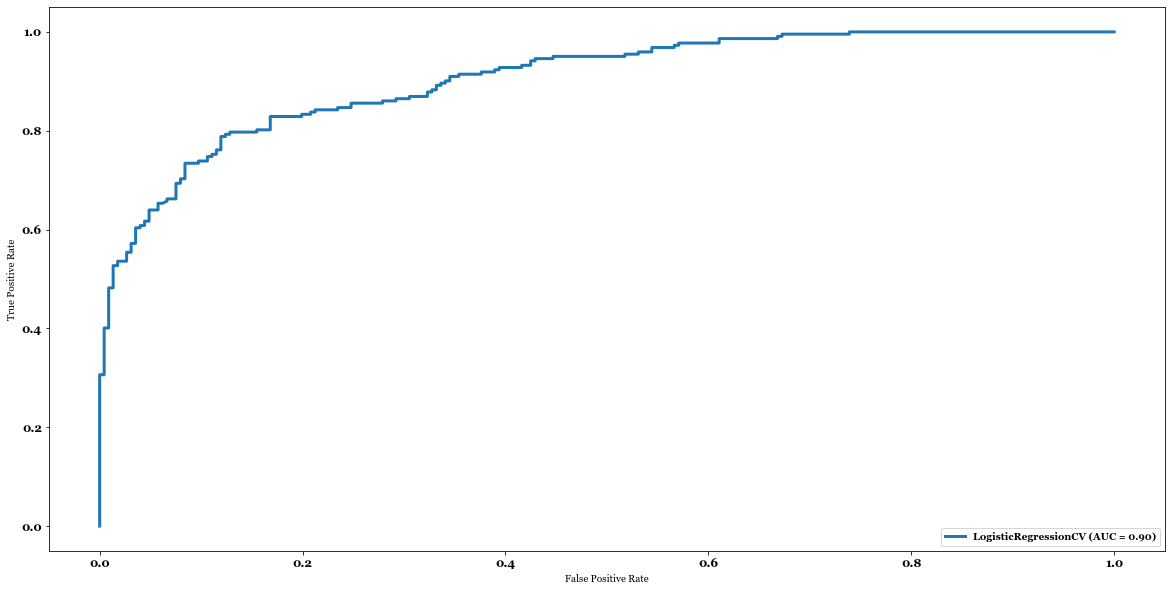

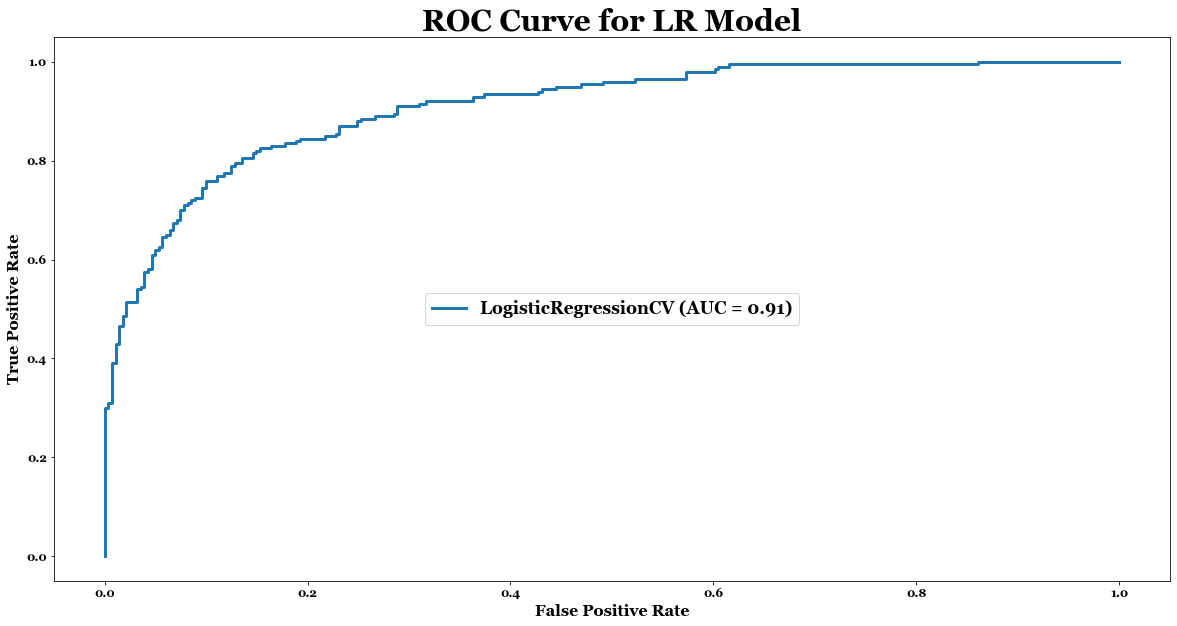

In [220]:
thresh_selection(cleanxtest, cleanytest, lr, 0.2, 0.7, 0.02)
curve = plot_roc_curve(lr, xtest, ytest, lw=3)
title = plt.title('ROC Curve for LR Model', fontweight='bold', fontsize=30)
ylabel = plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
xlabel = plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
leg = plt.legend(fontsize='xx-large', loc=10)

In [175]:
test_dp = data[(data['churn'] == 0)&(data['tenure'] < 60)&(data['num_visits'] ==1)]
test_dp

,Gender,530_AreaCode,EstBalance,Bal_0_30,Bal_31_60,Bal_61_90,BalOver90,InsEst,BalTotal,HasIns,age,child,tenure,LastVisit,churn,num_visits,Zip_96001,Zip_96022,Zip_96073,Zip_96080,Zip_96099,seen_by_1,seen_by_10,seen_by_2,seen_by_15,seen_by_6,seen_by_7
1943,1,1,25.9,0.0,0.0,0.0,0.0,0.0,0.0,1,61.000000,0,0,386,0,1,0,0,0,0,0,0,1,0,0,0,0
2224,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,78.000000,0,30,389,0,1,0,0,0,0,0,0,0,0,0,0,1
2234,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,37.000000,0,-139,132,0,1,0,0,0,0,0,1,0,0,0,0,0
2236,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,47.630565,0,0,398,0,1,0,0,0,0,0,0,0,0,1,0,0
2238,0,1,160.2,0.0,0.0,0.0,160.2,0.0,160.2,1,49.000000,0,0,396,0,1,0,0,0,0,0,0,0,0,0,0,1
2241,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,51.000000,0,1,391,0,1,1,0,0,0,0,0,1,0,0,0,0
2263,1,1,90.0,0.0,0.0,0.0,90.0,0.0,90.0,1,66.000000,0,16,340,0,1,0,0,0,0,0,0,0,0,0,0,1
2264,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,47.630565,0,1,354,0,1,0,0,0,0,0,0,0,0,0,0,1
2267,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,47.630565,0,0,355,0,1,0,0,0,0,0,0,0,0,0,0,1
2272,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,47.630565,0,2,347,0,1,0,0,0,0,0,0,0,0,0,0,1


In [178]:
test_dp.drop(['LastVisit', 'churn'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [187]:
preds = pd.Series(lr.predict_proba(test_dp)[:,1])
preds[preds > 0.5].describe(); lr.predict(test_dp)

count    38.000000
mean      0.683499
std       0.109927
min       0.534744
25%       0.597406
50%       0.658125
75%       0.731011
max       0.931396
dtype: float64

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1])

In [168]:
lr.predict_proba(test_dp.values)[0]

array([0.46525602, 0.53474398])

In [151]:
churn_pred = lr.predict(test_dp.values.reshape(1,-1))[0]
churn_proba = round(lr.predict_proba(test_dp.values.reshape(1,-1))[0][1]*100)
if churn_pred == 1:
    print(f'Patient is likely to churn with probability {churn_proba}%, you should do this...')

Patient is likely to churn with probability 69.0%, you should do this...


### Logistic Regression with statsmodel

In [109]:
log_reg = sm.Logit(ytrain, xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.395198
         Iterations 8


In [110]:
print(log_reg.summary(xname=X.columns.tolist()))

                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 1921
Model:                          Logit   Df Residuals:                     1896
Method:                           MLE   Df Model:                           24
Date:                Wed, 06 Jan 2021   Pseudo R-squ.:                  0.4216
Time:                        13:15:47   Log-Likelihood:                -759.18
converged:                       True   LL-Null:                       -1312.6
Covariance Type:            nonrobust   LLR p-value:                1.641e-218
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Gender          -0.0009      0.065     -0.014      0.989      -0.129       0.127
530_AreaCode    -0.0437      0.067     -0.654      0.513      -0.174       0.087
EstBalance       0.0736      0.068      1.08

In [111]:
np.exp(-0.9622 )

0.38205144754761716

In [60]:
print(log_reg.summary2(xname=X.columns.tolist()))

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.403      
Dependent Variable: churn            AIC:              1612.4011  
Date:               2021-01-06 12:31 BIC:              1751.4161  
No. Observations:   1921             Log-Likelihood:   -781.20    
Df Model:           24               LL-Null:          -1309.4    
Df Residuals:       1896             LLR p-value:      9.1302e-208
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Gender        -0.0633    0.0640   -0.9892  0.3226  -0.1886   0.0621
530_AreaCode   0.0102    0.0651    0.1559  0.8761  -0.1175   0.1378
EstBalance     0.1129    0.0688    1.6417  0.1006  -0.0219   0.2477
Bal_0_30      -

In [94]:
yhat = log_reg.predict(xtest)
predictions = list(map(round, yhat)) 

In [95]:
confusion_matrix(ytest, predictions)

array([[219,  47],
       [ 34, 181]])

In [96]:
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       266
           1       0.79      0.84      0.82       215

    accuracy                           0.83       481
   macro avg       0.83      0.83      0.83       481
weighted avg       0.83      0.83      0.83       481



In [140]:
coefs = pd.DataFrame().from_dict(dict(zip(X.columns, lr.coef_[0])), orient='index').sort_values(by=0)
coefs.rename(columns={0:'log_odds'}, inplace=True)

In [142]:
coefs['odds'] = np.exp(coefs['log_odds'])
coefs['probability'] = coefs.log_odds.apply(odds_to_prob)

In [143]:
coefs

,log_odds,odds,probability
num_visits,-1.281973,0.277489,0.217214
seen_by_10,-0.890760,0.410344,0.290953
InsEst,-0.740402,0.476922,0.322916
seen_by_15,-0.719637,0.486929,0.327473
seen_by_7,-0.492470,0.611115,0.379312
tenure,-0.230406,0.794211,0.442652
Bal_0_30,-0.210403,0.810258,0.447593
BalOver90,-0.188568,0.828144,0.452997
Zip_96073,-0.135139,0.873594,0.466267
child,-0.086936,0.916736,0.478280


In [322]:
gender = pd.read_csv('data/model_pat.csv')

In [325]:
gender.Gender.value_counts()/len(gender)

1    0.501249
0    0.498751
Name: Gender, dtype: float64